In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
# import ollama  # Ollama (Phi-4) 연결

c:\Users\korea\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()

# 전체 그래프에 적용할 폰트 설정
plt.rcParams["font.family"] = font_name

# 음수 기호(-)가 깨지지 않도록 설정
plt.rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    message=".*Could not find the number of physical cores.*"
)


In [3]:
# CUDA 사용 가능 여부 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# ---------------------------
# 1. Train 데이터 로드 및 전처리
# ---------------------------
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission = pd.read_csv("LB_0.5464_mean_vector_submission.csv", encoding="utf-8-sig")

# 데이터프레임 기본 구조 확인
print("DataFrame Info:")
train_df.info()

print("\nDataFrame Head:")
print(train_df.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23422 entries, 0 to 23421
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               23422 non-null  object
 1   발생일시             23422 non-null  object
 2   사고인지 시간          23422 non-null  object
 3   날씨               23422 non-null  object
 4   기온               23422 non-null  object
 5   습도               23422 non-null  object
 6   공사종류             23422 non-null  object
 7   연면적              23422 non-null  object
 8   층 정보             23422 non-null  object
 9   인적사고             23390 non-null  object
 10  물적사고             21932 non-null  object
 11  공종               23411 non-null  object
 12  사고객체             22735 non-null  object
 13  작업프로세스           23359 non-null  object
 14  장소               23422 non-null  object
 15  부위               23422 non-null  object
 16  사고원인             23359 non-null  object
 17  재발방지대책 및 향후조치계획


결측치 개수:
ID                    0
발생일시                  0
사고인지 시간               0
날씨                    0
기온                    0
습도                    0
공사종류                  0
연면적                   0
층 정보                  0
인적사고                 32
물적사고               1490
공종                   11
사고객체                687
작업프로세스               63
장소                    0
부위                    0
사고원인                 63
재발방지대책 및 향후조치계획       0
dtype: int64

✅ 결측치 처리 후 개수:
ID                 0
발생일시               0
사고인지 시간            0
날씨                 0
기온                 0
습도                 0
공사종류               0
연면적                0
층 정보               0
인적사고               0
물적사고               0
공종                 0
사고객체               0
작업프로세스             0
장소                 0
부위                 0
사고원인               0
재발방지대책 및 향후조치계획    0
dtype: int64

✅ 텍스트 길이 평균: 60.441708008504605
✅ 텍스트 길이 분산: 1239.736668338425
✅ 텍스트 길이 중앙값: 52.0


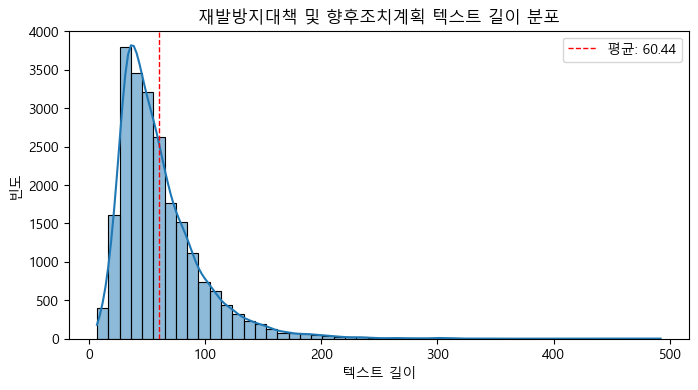

In [5]:
# ✅ 결측치 개수 확인
print("\n결측치 개수:")
print(train_df.isnull().sum())

# ✅ "물적사고"가 결측이면 "없음"으로 채우기
train_df["물적사고"] = train_df["물적사고"].fillna("없음")

# ✅ "인적사고", "공종", "사고객체", "작업프로세스", "사고원인" 결측치 제거
train_df = train_df.dropna(subset=["인적사고", "공종", "사고객체", "작업프로세스", "사고원인"])

# ✅ 테스트 데이터에도 동일한 처리 적용
test_df["물적사고"] = test_df["물적사고"].fillna("없음")
# 특정 열에서 NaN 값을 빈 문자열("")로 변경
columns_to_fill = ["인적사고", "공종", "사고객체", "작업프로세스", "사고원인"]
test_df[columns_to_fill] = test_df[columns_to_fill].fillna("")

# ✅ 결측치 처리 후 다시 확인
print("\n✅ 결측치 처리 후 개수:")
print(train_df.isnull().sum())

# ✅ 타깃 컬럼(재발방지대책 및 향후조치계획)의 길이 계산
train_df["plan_length"] = train_df["재발방지대책 및 향후조치계획"].apply(len)

# ✅ 텍스트 길이의 평균과 분산 계산
mean_length = train_df["plan_length"].mean()
variance_length = train_df["plan_length"].var()
median_length = train_df["plan_length"].median()

print("\n✅ 텍스트 길이 평균:", mean_length)
print("✅ 텍스트 길이 분산:", variance_length)
print("✅ 텍스트 길이 중앙값:", median_length)

# ✅ 텍스트 길이 분포 시각화
plt.figure(figsize=(8, 4))
sns.histplot(train_df["plan_length"], bins=50, kde=True)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'평균: {mean_length:.2f}')
plt.title("재발방지대책 및 향후조치계획 텍스트 길이 분포")
plt.xlabel("텍스트 길이")
plt.ylabel("빈도")
plt.legend()
plt.show()

In [7]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

device = "cuda" if torch.cuda.is_available() else "cpu"
# SentenceTransformer 모델 로드
model = SentenceTransformer("ibm-granite/granite-embedding-107m-multilingual", device=device)

# 필수 컬럼 확인
columns_needed = ["사고원인", "재발방지대책 및 향후조치계획"]
if not all(col in train_df.columns for col in columns_needed):
    raise ValueError(f"필수 컬럼 {columns_needed}이 데이터에 없습니다.")


In [8]:
# 벡터화 수행
vector_dict = {}  # 각 요소의 벡터 저장
for col in ["사고원인", "공종", "작업프로세스","인적사고","물적사고", "장소", "사고객체", "부위"]:
    vector_dict[col] = model.encode(train_df[col].tolist(), convert_to_numpy=True)

# 테스트 데이터 벡터화
test_vector_dict = {}
for col in ["사고원인", "공종", "작업프로세스","인적사고","물적사고", "장소", "사고객체", "부위"]:
    test_vector_dict[col] = model.encode(test_df[col].tolist(), convert_to_numpy=True)

In [9]:
# 임의의 가중치 (요소별 중요도)
weights = {
    "사고원인": 0.45,
    "공종": 0.15,
    "작업프로세스": 0.05,
    "인적사고":0.05,
    "물적사고":0.05,
    "장소": 0.05,
    "사고객체": 0.15,
    "부위": 0.05
}

# 유사도 행렬 계산 및 가중치 반영
similarity_matrices = {}
for col in weights.keys():
    similarity_matrices[col] = cosine_similarity(vector_dict[col])

# 최종 유사도 행렬 계산
final_similarity_matrix = sum(weights[col] * similarity_matrices[col] for col in weights)

# 유사한 사고 찾기 함수
def find_similar_accidents(index, top_n=5):
    """
    주어진 사고의 인덱스를 기반으로 가장 유사한 사고를 찾음.
    동일 사고는 제외하고 top_n개를 반환.
    """
    similarities = final_similarity_matrix[index]
    similar_indices = np.argsort(-similarities)[1:top_n+1]  # 자기 자신 제외, 상위 N개 선택
    return similar_indices, similarities[similar_indices]

# 특정 사고에 대해 유사 사고 찾기
example_index = 0  # 예제 인덱스
similar_indices, similarity_scores = find_similar_accidents(example_index)

# 결과 출력
print(f"\n🔹 기준 사고원인: {train_df['사고원인'].iloc[example_index]}")
print(f"🔹 기준 공종: {train_df['공종'].iloc[example_index]}")
print(f"🔹 기준 작업프로세스: {train_df['작업프로세스'].iloc[example_index]}")
print(f"🔹 기준 장소: {train_df['장소'].iloc[example_index]}")
print(f"🔹 기준 부위: {train_df['부위'].iloc[example_index]}")
print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[example_index]}\n")

for rank, (idx, score) in enumerate(zip(similar_indices, similarity_scores), start=1):
    print(f"🔸 {rank}번째 유사한 사고 (유사도: {score:.4f})")
    print(f"  🛑 사고원인: {train_df['사고원인'].iloc[idx]}")
    print(f"  🔹 공종: {train_df['공종'].iloc[idx]}")
    print(f"  🔹 작업프로세스: {train_df['작업프로세스'].iloc[idx]}")
    print(f"  🔹 장소: {train_df['장소'].iloc[idx]}")
    print(f"  🔹 부위: {train_df['부위'].iloc[idx]}")
    print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[idx]}\n")


🔹 기준 사고원인: 고소작업 중 추락 위험이 있음에도 불구하고, 안전난간대, 안전고리 착용 등 안전장치가 미흡하였음.
🔹 기준 공종: 건축 > 철근콘크리트공사
🔹 기준 작업프로세스: 설치작업
🔹 기준 장소: 근린생활시설 / 내부
🔹 기준 부위: 철근 / 고소
  ⮩ 대응 대책: 고소작업 시 추락 위험이 있는 부위에 안전장비 설치.

🔸 1번째 유사한 사고 (유사도: 0.8936)
  🛑 사고원인: 작업자가 안전화를 헐겁게 착용하여 철근 운반 중 데크에 걸려 안전화가 벚겨져 사고가 발생함.
  🔹 공종: 건축 > 철근콘크리트공사
  🔹 작업프로세스: 운반작업
  🔹 장소: 교육연구시설 / 내부
  🔹 부위: 철근 / 바닥
  ⮩ 대응 대책: 작업자 안전보호구 착용 적정 여부 교육 강화 및 실족 방지망 설치 예정.

🔸 2번째 유사한 사고 (유사도: 0.8861)
  🛑 사고원인: 데크플레이트 설치작업 중 안전고리 등 개인 안전장비를 착용하고 작업하였으나, 데크 중앙부에서 작업을 위해 임시로 안전고리를 해제 후 작업하다가 근로자가  발을 헛딛여 낙상하는 사고가 발생하였습니다.
  🔹 공종: 건축 > 철골공사
  🔹 작업프로세스: 설치작업
  🔹 장소: 자동차 관련시설 / 내부
  🔹 부위: 철골부재 / 상부(위)
  ⮩ 대응 대책: 작업 전 개별 안전장비 착용 여부 확인과 근로자 안전 교육 실시를 통한 사고 재발 방지 대책 마련.

🔸 3번째 유사한 사고 (유사도: 0.8846)
  🛑 사고원인: 크레인걸이와 브레이스철골 부재의 탈락으로 인한 작업자 추락사고로 현장대리인이 현장에 상주하여야하나 비상주하였으며, 작업인부는 안전모, 안전화, 안전조끼는 착용하였으나, 고소작업시 착용하여야하는 안전고리를 미부착 함
  🔹 공종: 건축 > 철골공사
  🔹 작업프로세스: 설치작업
  🔹 장소: 교육연구시설 / 철골구조체
  🔹 부위: 철골부재 / 고소
  ⮩ 대응 대책: 현장대리인 안전조치 계획에 따른 안전방호조치 및 개인보호구 착용 철저와 고용노동부 심의 결과에 따른 조

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

"""
Self-Supervised Learning (자기 지도 학습)
WeightedFeatureMLP 모델을 적용하여 각 사고 요소(Feature)의 중요도(가중치)를 직접 학습하고,
이를 반영하여 사고 요소 조합과 조치 계획(Measure) 간의 관계를 정교하게 학습.
"""
# -------------------------
# (1) 데이터 준비 (기존 코드 활용 및 수정)
# -------------------------
# 필요한 컬럼 정의 (기존과 동일)
columns_needed = ["사고원인", "재발방지대책 및 향후조치계획"]
if not all(col in train_df.columns for col in columns_needed):
    raise ValueError(f"필수 컬럼 {columns_needed}이 데이터에 없습니다.")

# 가중치를 학습할 사고 요소(Feature) 컬럼 목록 (기존 K개 변수 사용)
# **주의:** '인적사고', '물적사고' 컬럼의 데이터 타입 및 임베딩 방식 확인 필요.
#          만약 이들이 범주형이라면 임베딩 방식이 달라야 할 수 있습니다.
#          여기서는 다른 텍스트 컬럼과 동일하게 임베딩 가능하다고 가정합니다.
factor_cols = ["사고원인", "공종", "작업프로세스", "인적사고", "물적사고", "장소", "사고객체", "부위"]
K = len(factor_cols) # 특징(변수)의 개수, 여기서는 8

# 각 사고 요소를 임베딩하여 딕셔너리에 저장 (기존과 유사)
# 각 value는 [N, D] 형태의 텐서
vector_dict = {
    col: torch.tensor(
        model.encode(train_df[col].astype(str).tolist(), convert_to_numpy=True), # .astype(str) 추가하여 안정성 확보
        device=device,
        dtype=torch.float32
    )
    for col in factor_cols
}

# 비교 기준이 될 '조치 계획' 임베딩 (기존과 동일)
# shape: [N, D]
measure_vectors = torch.tensor(
    model.encode(train_df["재발방지대책 및 향후조치계획"].astype(str).tolist(), convert_to_numpy=True),
    device=device,
    dtype=torch.float32
)

N = measure_vectors.shape[0]  # 샘플 수
# D_feature는 각 feature의 임베딩 차원 (모든 feature가 동일 차원이라고 가정)
if K > 0:
  D_feature = vector_dict[factor_cols[0]].shape[1] # 예: 768
else:
  raise ValueError("factor_cols가 비어있습니다.")

# =====================================================================
# ✅ 핵심 데이터 변경: 모든 특징(factor_cols) 임베딩을 샘플별로 연결(concatenate)
# =====================================================================
# WeightedFeatureMLP 모델은 각 샘플에 대해 모든 특징 정보를 하나의 벡터로 입력받아야 합니다.
# vector_dict의 텐서들을 1번 차원(dim=1)을 따라 연결합니다.
# 예: [N, D_feature] 텐서 K개를 연결 -> [N, K * D_feature] 텐서 생성
# shape: [N, 8 * 768] = [N, 6144] (만약 D_feature=768이라면)
concatenated_incident_vectors = torch.cat([vector_dict[col] for col in factor_cols], dim=1).to(device)
TOTAL_INPUT_DIM = concatenated_incident_vectors.shape[1] # K * D_feature
# =====================================================================


# -----------------------------------------
# (2) 새로운 모델 정의: WeightedFeatureMLP
# -----------------------------------------
# 기존 WeightPredictor 대신 이 모델을 사용합니다.
class WeightedFeatureMLP(nn.Module):
    """
    K개의 입력 특징(변수) 각각에 대한 중요도(가중치)를 직접 학습하고,
    가중치가 적용된 특징 벡터를 MLP에 통과시켜 최종 임베딩을 출력하는 모델.
    """
    # --- 모델 초기화 함수 ---
    def __init__(self, num_features=K, feature_dim=D_feature, hidden_dim=128, output_dim=256):
        """
        Args:
            num_features (int): 입력 특징(변수)의 개수 (K).
            feature_dim (int): 각 특징(변수)의 임베딩 차원 (D_feature).
            hidden_dim (int): MLP의 은닉층 차원.
            output_dim (int): 모델이 최종적으로 출력할 임베딩 차원 (Contrastive Loss 비교용).
                               이 차원은 measure_vectors의 차원(D_feature)과 달라도 됩니다.
        """
        super(WeightedFeatureMLP, self).__init__()
        self.num_features = num_features         # 특징 개수 (K) 저장
        self.feature_dim = feature_dim           # 특징별 차원 (D_feature) 저장
        self.total_input_dim = num_features * feature_dim # 총 입력 차원 (K * D_feature)

        # --- ✅ 학습 가능한 특징 가중치 파라미터 ---
        # 크기가 K인 텐서를 nn.Parameter로 등록하여 학습 가능하게 만듭니다.
        # 이 파라미터가 역전파를 통해 업데이트되며, 특징들의 중요도를 학습합니다.
        self.feature_weights_raw = nn.Parameter(torch.zeros(num_features))
        # 주석: 이 값 자체는 가중치가 아니며, softmax를 통과한 값이 실제 가중치로 사용됩니다.

        # --- MLP 레이어 정의 ---
        # 가중치가 적용된 특징 벡터(total_input_dim 차원)를 입력받아 최종 임베딩(output_dim 차원)을 만듭니다.
        self.fc1 = nn.Linear(self.total_input_dim, hidden_dim) # 입력층 -> 은닉층
        self.fc2 = nn.Linear(hidden_dim, output_dim)          # 은닉층 -> 출력층

    # --- 정규화된 가중치 반환 함수 ---
    def get_normalized_weights(self):
        """
        학습된 feature_weights_raw에 softmax를 적용하여 합이 1인 가중치를 반환합니다.
        """
        return F.softmax(self.feature_weights_raw, dim=0)

    # --- 모델 순전파 로직 ---
    def forward(self, x):
        """
        Args:
            x (torch.Tensor): K개 특징 임베딩이 concat된 입력 텐서.
                              Shape: [batch_size, total_input_dim (K * D_feature)]
        Returns:
            torch.Tensor: 모델이 출력하는 최종 임베딩. Shape: [batch_size, output_dim]
        """
        # 1. 현재 학습된 정규화된 가중치 얻기 (shape: [K])
        normalized_weights = self.get_normalized_weights()

        # 2. 가중치 확장: [K] -> [total_input_dim] 형태로 확장
        #    각 특징 블록(D_feature 차원) 전체에 해당 가중치가 적용되도록 함.
        weights_expanded = torch.repeat_interleave(normalized_weights, self.feature_dim) # shape: [K * D_feature]

        # 3. 가중치 적용: 입력 x에 확장된 가중치를 요소별로 곱함 (Broadcasting 활용)
        #    shape: [batch_size, total_input_dim]
        weighted_x = x * weights_expanded.unsqueeze(0)

        # 4. MLP 통과: 가중치가 적용된 입력을 fc1, relu, fc2 순으로 통과시켜 최종 임베딩 생성
        h = F.relu(self.fc1(weighted_x))  # shape: [batch_size, hidden_dim]
        output_embedding = self.fc2(h)    # shape: [batch_size, output_dim]

        return output_embedding

# =====================================================================
# ✅ 모델 생성 및 옵티마이저 설정 (새로운 모델 사용)
# =====================================================================
# 사용할 하이퍼파라미터 설정
HIDDEN_DIM_MLP = 128 # MLP 은닉층 크기
OUTPUT_DIM_MLP = 256 # 모델 최종 출력 임베딩 크기 (measure_vectors 차원과 달라도 됨)

# WeightedFeatureMLP 모델 인스턴스 생성 및 GPU 이동
model_new = WeightedFeatureMLP(
    num_features=K,
    feature_dim=D_feature,
    hidden_dim=HIDDEN_DIM_MLP,
    output_dim=OUTPUT_DIM_MLP
).to(device)

# 옵티마이저 설정: AdamW 사용, model_new의 모든 파라미터(가중치 + MLP 레이어)를 학습 대상으로 지정
optimizer = torch.optim.AdamW(model_new.parameters(), lr=5e-4, weight_decay=1e-4) # 기존 lr, weight_decay 값 사용하거나 조절
# =====================================================================


# ---------------------------------
# (3) 수정된 Pairwise Loss 함수 (Contrastive 방식 적용)
# ---------------------------------
# 임계값 및 마진 정의 (하이퍼파라미터)
SIMILARITY_THRESHOLD = 0.8 # 이 값 이상이면 '유사한 쌍'으로 간주
CONTRASTIVE_MARGIN = 0.3   # 유사하지 않은 쌍이 가져야 할 최대 유사도 (이 값보다 작아지도록 유도)

def pairwise_loss_contrastive(model, batch_size=1024, threshold=SIMILARITY_THRESHOLD, margin=CONTRASTIVE_MARGIN):
    """
    WeightedFeatureMLP 모델을 사용하여 Contrastive Loss를 계산합니다.
    실제 조치계획 유사도(measure_sim)가 threshold 이상인 쌍은 모델 유사도(factor_sim)를 1에 가깝게,
    threshold 미만인 쌍은 모델 유사도(factor_sim)를 margin보다 작게 만들도록 학습합니다.

    Args:
        model (nn.Module): 학습시킬 WeightedFeatureMLP 모델 인스턴스.
        batch_size (int): 각 step에서 사용할 샘플 쌍의 개수.
        threshold (float): 유사/비유사 쌍을 나누는 measure_sim 임계값.
        margin (float): 유사하지 않은 쌍이 가져야 할 최대 유사도 값.

    Returns:
        torch.Tensor: 계산된 Contrastive Loss 값 (스칼라).
    """
    model.train() # 모델을 학습 모드로 설정

    # --- 1. 데이터 샘플링 (이전과 동일) ---
    idx_i = torch.randint(0, N, (batch_size,), device=device)
    idx_j = torch.randint(0, N, (batch_size,), device=device)
    incident_i_input = concatenated_incident_vectors[idx_i]
    incident_j_input = concatenated_incident_vectors[idx_j]
    m_i = measure_vectors[idx_i]
    m_j = measure_vectors[idx_j]

    # --- 2. 모델 순전파 (이전과 동일) ---
    factor_embed_i = model(incident_i_input)
    factor_embed_j = model(incident_j_input)

    # --- 3. 유사도 계산 (이전과 동일) ---
    # 모델 출력 임베딩 간 유사도 (모델의 판단)
    factor_sim = F.cosine_similarity(factor_embed_i, factor_embed_j, dim=1)
    # 실제 기준 데이터(measure) 간 유사도 (실제 정답 유사도)
    measure_sim = F.cosine_similarity(m_i, m_j, dim=1)

    # =====================================================================
    # --- 4. Contrastive Loss 계산 (핵심 변경 부분) ---
    # =====================================================================
    # 실제 유사도(measure_sim)를 기준으로 라벨(labels) 생성
    # measure_sim >= threshold 이면 유사한 쌍(label=1.0), 아니면 다른 쌍(label=0.0)
    labels = (measure_sim >= threshold).float()

    # Contrastive Loss 계산:
    # Loss for similar pairs (labels=1.0): 모델 유사도(factor_sim)가 1에 가까워지도록 (1 - factor_sim)^2
    loss_similar = (1 - factor_sim) ** 2

    # Loss for dissimilar pairs (labels=0.0): 모델 유사도(factor_sim)가 margin 값보다 작아지도록
    # clamp(factor_sim - margin, min=0)^2 : factor_sim이 margin보다 클 때만 패널티 부여
    loss_dissimilar = torch.clamp(factor_sim - margin, min=0) ** 2

    # 최종 Loss: 라벨에 따라 두 종류의 Loss를 조합
    # 유사한 쌍에는 loss_similar 적용, 다른 쌍에는 loss_dissimilar 적용
    loss = labels * loss_similar + (1 - labels) * loss_dissimilar
    # =====================================================================

    # 배치 내 모든 샘플 쌍에 대한 손실의 평균을 반환
    return loss.mean()

# -------------------------
# (4) 학습 루프 실행 (수정됨)
# -------------------------
max_steps = 30000
print("--- 학습 시작 (WeightedFeatureMLP 사용) ---")
for step in range(max_steps):
    # 옵티마이저 그래디언트 초기화
    optimizer.zero_grad()

    # ✅ 수정된 Loss 함수 호출 (모델 인스턴스 전달)
    loss_val = pairwise_loss_contrastive(model_new, batch_size=1024)

    # 그래디언트 계산 (역전파)
    loss_val.backward()

    # 모델 파라미터 업데이트 (옵티마이저 실행)
    optimizer.step()

    # --- 중간 결과 출력 (매 200 스텝마다) ---
    if step % 200 == 0:
        # 모델을 평가 모드로 전환 (Dropout 등 비활성화)
        model_new.eval()
        # 그래디언트 계산 비활성화
        with torch.no_grad():
            # ✅ 현재 학습된 가중치 확인 (get_normalized_weights 사용)
            current_weights = model_new.get_normalized_weights()
            weights_str = ", ".join([f"{w:.4f}" for w in current_weights.cpu().numpy()])
            print(f"[Step {step:5d}] loss={loss_val.item():.6f}, alpha=[{weights_str}]")

# -------------------------
# (5) 최종 가중치 출력 (수정됨)
# -------------------------
print("\n--- 학습 완료 ---")
# 모델을 평가 모드로 설정
model_new.eval()
# 그래디언트 계산 비활성화
with torch.no_grad():
    # ✅ 최종 학습된 가중치 가져오기
    final_weights = model_new.get_normalized_weights().data.cpu().numpy()

# 최종 가중치를 딕셔너리 형태로 저장 (기존과 동일)
optimal_weights = {col: round(float(final_weights[i]), 4) for i, col in enumerate(factor_cols)}
print("\n✅ 최종 학습된 최적 가중치:", optimal_weights)

# 이제 optimal_weights를 calculate_weighted_cosine_similarity 함수 등에 사용할 수 있습니다.
# final_weights_tensor = torch.tensor(final_weights, device=device) # 필요시 텐서로 변환

--- 학습 시작 (WeightedFeatureMLP 사용) ---
[Step     0] loss=0.349599, alpha=[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]
[Step   200] loss=0.153940, alpha=[0.1240, 0.1244, 0.1240, 0.1267, 0.1238, 0.1250, 0.1264, 0.1258]
[Step   400] loss=0.125509, alpha=[0.1245, 0.1237, 0.1249, 0.1273, 0.1239, 0.1248, 0.1258, 0.1251]
[Step   600] loss=0.111195, alpha=[0.1250, 0.1237, 0.1253, 0.1275, 0.1239, 0.1246, 0.1254, 0.1247]
[Step   800] loss=0.122965, alpha=[0.1253, 0.1236, 0.1255, 0.1275, 0.1240, 0.1245, 0.1251, 0.1245]
[Step  1000] loss=0.113227, alpha=[0.1256, 0.1237, 0.1253, 0.1274, 0.1239, 0.1245, 0.1249, 0.1247]
[Step  1200] loss=0.112875, alpha=[0.1259, 0.1236, 0.1251, 0.1272, 0.1238, 0.1244, 0.1248, 0.1251]
[Step  1400] loss=0.108079, alpha=[0.1262, 0.1236, 0.1249, 0.1270, 0.1237, 0.1243, 0.1248, 0.1255]
[Step  1600] loss=0.107517, alpha=[0.1265, 0.1235, 0.1248, 0.1268, 0.1236, 0.1242, 0.1248, 0.1260]
[Step  1800] loss=0.102766, alpha=[0.1266, 0.1236, 0.1246, 0.1265, 0.12

In [11]:
# ✅ 최종 학습된 최적 가중치: 
optimal_weights = {'사고원인': 0.4515, '공종': 0.0678, '작업프로세스': 0.0695, '인적사고': 0.0495, '물적사고': 0.0291, '장소': 0.124, '사고객체': 0.0425, '부위': 0.166}

weights = optimal_weights

# ✅ 유사도 행렬 계산 및 가중치 반영
similarity_matrices = {}
for col in weights.keys():
    similarity_matrices[col] = cosine_similarity(vector_dict[col].cpu().numpy())  # GPU -> CPU 변환

# ✅ 최종 유사도 행렬 계산 (가중 평균)
final_similarity_matrix = sum(weights[col] * similarity_matrices[col] for col in weights)

# ✅ 유사한 사고 찾기 함수
def find_similar_accidents(index, top_n=5):
    """
    주어진 사고의 인덱스를 기반으로 가장 유사한 사고를 찾음.
    자기 자신을 제외하고 top_n개를 반환.
    """
    similarities = final_similarity_matrix[index]
    similar_indices = np.argsort(-similarities)[1:top_n+1]  # 자기 자신 제외, 상위 N개 선택
    return similar_indices, similarities[similar_indices]

# ✅ 특정 사고에 대해 유사 사고 찾기
example_index = 0  # 예제 인덱스 (원하는 인덱스로 변경 가능)
similar_indices, similarity_scores = find_similar_accidents(example_index)

# ✅ 결과 출력
print(f"\n🔹 기준 사고원인: {train_df['사고원인'].iloc[example_index]}")
print(f"🔹 기준 공종: {train_df['공종'].iloc[example_index]}")
print(f"🔹 기준 작업프로세스: {train_df['작업프로세스'].iloc[example_index]}")
print(f"🔹 기준 인적사고: {train_df['인적사고'].iloc[example_index]}")
print(f"🔹 기준 물적사고: {train_df['물적사고'].iloc[example_index]}")
print(f"🔹 기준 장소: {train_df['장소'].iloc[example_index]}")
print(f"🔹 기준 부위: {train_df['부위'].iloc[example_index]}")
print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[example_index]}\n")

for rank, (idx, score) in enumerate(zip(similar_indices, similarity_scores), start=1):
    print(f"🔸 {rank}번째 유사한 사고 (유사도: {score:.4f})")
    print(f"  🛑 사고원인: {train_df['사고원인'].iloc[idx]}")
    print(f"  🔹 공종: {train_df['공종'].iloc[idx]}")
    print(f"  🔹 작업프로세스: {train_df['작업프로세스'].iloc[idx]}")
    print(f"  🔹 인적사고: {train_df['인적사고'].iloc[example_index]}")
    print(f"  🔹 기적사고: {train_df['물적사고'].iloc[example_index]}")  
    print(f"  🔹 장소: {train_df['장소'].iloc[idx]}")
    print(f"  🔹 부위: {train_df['부위'].iloc[idx]}")
    print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[idx]}\n")


🔹 기준 사고원인: 고소작업 중 추락 위험이 있음에도 불구하고, 안전난간대, 안전고리 착용 등 안전장치가 미흡하였음.
🔹 기준 공종: 건축 > 철근콘크리트공사
🔹 기준 작업프로세스: 설치작업
🔹 기준 인적사고: 떨어짐(5미터 이상 ~ 10미터 미만)
🔹 기준 물적사고: 없음
🔹 기준 장소: 근린생활시설 / 내부
🔹 기준 부위: 철근 / 고소
  ⮩ 대응 대책: 고소작업 시 추락 위험이 있는 부위에 안전장비 설치.

🔸 1번째 유사한 사고 (유사도: 0.8781)
  🛑 사고원인: 고소작업 시 추락 및 낙상 사고 방지를 위해 안전대를 착용하여야 하나, 빠른 작업을 위해 안전대를 착용하지 않았고, 작업자 및 현장 관리자의 안전관리에 소홀하였음
  🔹 공종: 토목 > 지반개량공사
  🔹 작업프로세스: 조립작업
  🔹 인적사고: 떨어짐(5미터 이상 ~ 10미터 미만)
  🔹 기적사고: 없음
  🔹 장소: 절토사면 / 외벽
  🔹 부위: 고소작업차(고소작업대 등) / 고소
  ⮩ 대응 대책: 작업 전 위험요인에 대한 한전교육 실시 및 근로자 상태 확인, 보호구 착용 철저, 시공사의 안전사고 재발방지 대책 이행여부 점검 및 관리감독 철저.

🔸 2번째 유사한 사고 (유사도: 0.8746)
  🛑 사고원인: 매일아침 고소작업 및 안전보호구 착용교육실시 와 안전보호구 지급을 하였고 제설작업 실시를 하였음에도 안전보호구 착용하지않고 고소작업중 전일 내린 눈에의해 미끄러져 하부로 추락사고 발생.
  🔹 공종: 토목 > 말뚝공사
  🔹 작업프로세스: 정비작업
  🔹 인적사고: 떨어짐(5미터 이상 ~ 10미터 미만)
  🔹 기적사고: 없음
  🔹 장소: 숙박시설 / C.I.P 파일천공
  🔹 부위: 천공기 / 상부(위)
  ⮩ 대응 대책: 현장 내 전인원 안전벨트 착용 의무화 및 재발 방지 교육 실시와 안전 교육 철저.

🔸 3번째 유사한 사고 (유사도: 0.8722)
  🛑 사고원인: 사고발생 전 아침조회를 실시하면서 금일 작업 관련 중점관리 위험요소로 보 거푸집 상부에서 작업

In [12]:
# 3. --- 테스트 데이터와 학습 데이터 간 유사도 계산 ---
similarity_matrices_test = {}

# 테스트 데이터 벡터화
test_vector_dict = {
    col: torch.tensor(
        model.encode(test_df[col].tolist(), convert_to_numpy=True),
        device=device,
        dtype=torch.float32
    )
    for col in factor_cols
}

for col in factor_cols:
    # cosine_similarity()는 numpy 배열을 요구하므로 GPU -> CPU 변환 추가
    similarity_matrices_test[col] = cosine_similarity(
        test_vector_dict[col].cpu().numpy(),  # ✅ GPU → CPU 변환
        vector_dict[col].cpu().numpy()  # ✅ GPU → CPU 변환
    )

# 4. --- 최적 가중치를 반영하여 최종 유사도 행렬 생성 ---
final_similarity_test = np.zeros_like(list(similarity_matrices_test.values())[0])

for col in factor_cols:
    final_similarity_test += optimal_weights[col] * similarity_matrices_test[col]  # ✅ 가중치 반영

# 5. --- 유사 사고 찾기 함수 ---
def find_similar_accidents_for_test(test_index, top_n=5):
    """
    주어진 테스트 샘플(test_index)의 사고원인, 공종, 작업프로세스, 장소, 부위를 고려하여,
    학습 데이터(train_df)에서 가장 유사한 사례 top_n개를 반환합니다.
    """
    similarities = final_similarity_test[test_index]
    
    # 예외 처리: 유사도 배열 길이가 top_n보다 작다면 조정
    top_n = min(top_n, len(similarities))

    # 유사도가 높은 순으로 정렬하여 top_n 선택
    similar_indices = np.argsort(-similarities)[:top_n]
    
    # 반환: (유사 사고 인덱스, 해당 유사도 값)
    return similar_indices, similarities[similar_indices]

# 6. --- 예제 실행 ---
test_index = 0  # 테스트 데이터 중 첫 번째 샘플
top_n_results = find_similar_accidents_for_test(test_index, top_n=5)

print("유사 사고 인덱스:", top_n_results[0])  # 학습 데이터에서 유사도가 높은 사고 인덱스
print("유사도 점수:", top_n_results[1])  # 유사도 점수

유사 사고 인덱스: [16986  9315 21451 14288 10271]
유사도 점수: [0.86999977 0.86656386 0.85775524 0.8516767  0.83999074]


In [13]:
from langdetect import detect

def is_chinese(text):
    try:
        return detect(text) == "zh-cn"  # 중국어 감지
    except:
        return False  # 감지 실패 시 안전하게 처리
    
def generate_rag_response(top_k_cases, 기준_사고객체, 기준_사고원인, 기준_공종, 기준_작업프로세스, 기준_장소, 기준_부위, 기준_인적사고, 기준_물적사고):
    system_message = (
        "<|im_start|>system\n"
        "당신은 한국인 건설 사고 전문가입니다.\n"
        "주어진 유사 사고 사례들을 참고하여, 가장 효과적인 재발방지대책 및 향후 조치 계획을 작성해야 합니다.\n"
        "답변은 반드시 한국어로 작성해야 하며, 한 문장 내에서 각 요소를 반영하여 작성하세요.\n"
        "출력 형식: '대응대책:'으로 시작하는 한 문장으로 작성하세요.\n"
        "<|im_end|>"
    )

    user_message = (
        "<|im_start|>user\n"
        "[기준 사고]\n"
        f"- 사고객체: {기준_사고객체}\n"
        f"- 사고원인: {기준_사고원인}\n"
        f"- 인적사고: {기준_인적사고}\n"
        f"- 물적사고: {기준_물적사고}\n"
        f"- 공종: {기준_공종}\n"
        f"- 작업프로세스: {기준_작업프로세스}\n"
        f"- 장소: {기준_장소}\n"
        f"- 부위: {기준_부위}\n\n"
        "[유사 사례 - 기존 대응 대책들]:\n" +
        "\n".join([
            f"{i+1}. 사고객체: {case[0]}, 사고원인: {case[1]}, 인적사고: {case[2]}, 물적사고: {case[3]}, 공종: {case[4]}, "
            f"작업프로세스: {case[5]}, 장소: {case[6]}, 부위: {case[7]}, 대응 대책: {case[8]}"
            for i, case in enumerate(top_k_cases)
        ]) + "\n\n"
        "위의 유사 사례들을 참고하여, 기준 사고에 대한 최적의 재발방지대책 및 향후 조치 계획을 작성하세요.\n"
        "출력 형식: 반드시 '대응대책:'으로 시작하는 한 문장으로 작성하세요.\n"
        "<|im_end|>"
    )

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]
    
    while True:
        response = ollama.chat(model="qwq", messages=messages)
        output = response["message"]["content"]
        
        if not is_chinese(output):  # 중국어가 없으면 반환
            return output
        
        print("❌ 중국어 감지됨. 다시 요청 중...")



In [14]:
def process_test_cases_with_llm(test_df, final_similarity_test, train_df, top_n=5, output_csv="llm_results.csv"):
    """
    test_df의 각 샘플에 대해, 학습 데이터와의 최종 유사도를 기반으로 상위 유사 사례(top_n)를 추출한 후,
    generate_rag_response 함수를 호출하여 LLM(QWQ32B) 결과(최적의 재발방지대책 및 향후 조치 계획)를 생성합니다.
    결과는 콘솔에 출력하고, CSV 파일로 저장합니다.
    """
    results = []  # LLM 결과 저장 리스트
    count = 0
    # test_df의 각 샘플에 대해 처리
    for test_idx in tqdm(range(len(test_df)), desc="Processing test cases with LLM"):
        # 학습 데이터와의 최종 유사도에서 상위 top_n 사례 추출 (내림차순 정렬)
        similarities = final_similarity_test[test_idx]
        similar_indices = np.argsort(-similarities)[:top_n]
        
        # 상위 유사 사례에 대한 (사고객체, 사고원인, 인적사고, 물적사고, 공종, 작업프로세스, 장소, 부위, 대응 대책) 튜플 리스트 생성
        top_k_cases = [
            (
                train_df.iloc[i]["사고객체"],
                train_df.iloc[i]["사고원인"],
                train_df.iloc[i]["인적사고"],
                train_df.iloc[i]["물적사고"],
                train_df.iloc[i]["공종"],
                train_df.iloc[i]["작업프로세스"],
                train_df.iloc[i]["장소"],
                train_df.iloc[i]["부위"],
                train_df.iloc[i]["재발방지대책 및 향후조치계획"]
            )
            for i in similar_indices
        ]
        
        # 기준 사고 정보 추출
        기준_사고객체 = test_df.iloc[test_idx]["사고객체"]
        기준_사고원인 = test_df.iloc[test_idx]["사고원인"]
        기준_인적사고 = test_df.iloc[test_idx]["인적사고"]
        기준_물적사고 = test_df.iloc[test_idx]["물적사고"]
        기준_공종 = test_df.iloc[test_idx]["공종"]
        기준_작업프로세스 = test_df.iloc[test_idx]["작업프로세스"]
        기준_장소 = test_df.iloc[test_idx]["장소"]
        기준_부위 = test_df.iloc[test_idx]["부위"]
        
        # LLM 프롬프트에 따라 최적 대응 대책 생성
        rag_result = generate_rag_response(
            top_k_cases, 기준_사고객체, 기준_사고원인, 기준_공종, 기준_작업프로세스, 기준_장소, 기준_부위, 기준_인적사고, 기준_물적사고
        )
        results.append(rag_result)
        if count < 5:
            # 콘솔 출력 (각 테스트 샘플 별 상세 정보)
            print(f"--- Test Sample {test_idx} ---")
            print(f"테스트 사고객체: {기준_사고객체}")
            print(f"테스트 사고원인: {기준_사고원인}")
            print(f"테스트 공종: {기준_공종}")
            print(f"테스트 작업프로세스: {기준_작업프로세스}")
            print(f"테스트 장소: {기준_장소}")
            print(f"테스트 부위: {기준_부위}")
            print("유사 학습 사례:")
            for rank, i in enumerate(similar_indices, start=1):
                print(f"  {rank}. 사고객체: {train_df.iloc[i]['사고객체']}")
                print(f"     사고원인: {train_df.iloc[i]['사고원인']}")
                print(f"     공종: {train_df.iloc[i]['공종']}")
                print(f"     작업프로세스: {train_df.iloc[i]['작업프로세스']}")
                print(f"     장소: {train_df.iloc[i]['장소']}")
                print(f"     부위: {train_df.iloc[i]['부위']}")
                print(f"     대응 대책: {train_df.iloc[i]['재발방지대책 및 향후조치계획']}")
                print(f"     유사도: {similarities[i]:.4f}")
            print("=== LLM 최종 결과 ===")
            print(rag_result)
            print("\n" + "-"*80 + "\n")
            count += 1
    
    # test_df에 LLM 결과를 추가하고 CSV 파일로 저장
    results_df = test_df.copy()
    results_df["LLM_결과"] = results
    results_df.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"LLM 결과가 '{output_csv}' 파일에 저장되었습니다.")
    
    return results_df

In [15]:
# 유사 사고 분석 및 LLM 결과 생성 실행
results_df = process_test_cases_with_llm(
    test_df=test_df,
    final_similarity_test=final_similarity_test,
    train_df=train_df,
    top_n=5,
    output_csv="llm_results_allfeatureobject2.csv"
)


Processing test cases with LLM:   0%|          | 1/964 [00:30<8:11:42, 30.64s/it]

--- Test Sample 0 ---
테스트 사고객체: 건설기계 > 콘크리트펌프
테스트 사고원인: 펌프카 아웃트리거 바닥 고임목을 3단으로 보강 했음에도, 지반 침하(아웃트리거 우측 상부 1개소)가 발생하였고,  좌, 우측 아웃트리거의 펼친 길이가 상이하고 타설 위치가 건물 끝부분 모서리에 위치하여 붐대호스를 최대로 펼치다 보니 장비에 대한 무게중심이 한쪽으로 쏠려 일부 전도되는 사고가 발생된 것으로 판단됨
테스트 공종: 건축 > 철근콘크리트공사
테스트 작업프로세스: 타설작업
테스트 장소: 교정 및 군사시설 / 외부
테스트 부위: 콘크리트펌프 / 바닥
유사 학습 사례:
  1. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 지반침하로 인하여 펌프카 왼쪽 앞 지지대가 침하되면서 전도 되었고 이에따라 붐대에 작업자가 깔리면서 사고 발생
     공종: 건축 > 철근콘크리트공사
     작업프로세스: 타설작업
     장소: 관광 휴게시설 / 외부
     부위: 콘크리트펌프 / 바닥
     대응 대책: 안전교육 실시와 안전관리 강화를 통한 재발 방지 대책 마련.
     유사도: 0.8700
  2. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 펌프카 붐대를 최대거리로 사용하면서 하중이 집중되어 아웃트리거 지반이 붕괴.
     공종: 건축 > 철근콘크리트공사
     작업프로세스: 타설작업
     장소: 공장 / 내부
     부위: 콘크리트펌프 / 바닥 버림 타설 중
     대응 대책: 관리적 대책으로 차량계 건설기계 작업계획서 작성 및 검토와 펌프카 안전점검 체크리스트에 의한 사전 점검, 기술적 대책으로 펌프카 아웃트리거 설치 시 지반상태 사전 점검 및 받침대 추가 설치 확인, 유도자 또는 신호수 배치, 작업구역 설정, 타 근로자 출입금지 조치, 교육적 대책으로 펌프카 작업 전 안전교육 실시 및 확인, 당 작업 전 TBM 시 작업내용 및 위험포인트 내용 공유, 향후 조치 계획으로 재발 방지 대책 수립 및 현장 관리 철저.
     

Processing test cases with LLM:   0%|          | 2/964 [00:47<6:00:02, 22.46s/it]

--- Test Sample 1 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자의 불안전한 행동(숫돌 측면 사용) 및 보안면 미 착용
테스트 공종: 건축 > 수장공사
테스트 작업프로세스: 절단작업
테스트 장소: 운수시설 / 내부
테스트 부위: 공구류 / 핸드그라인더
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 보안경 미착용 및 불안전한 작업자세
     공종: 기계설비 > 기계설비공사
     작업프로세스: 조립작업
     장소: 업무시설 / 내부
     부위: 공구류 / 지하
     대응 대책: 관련 근로자 보안경 일체형 안전모 지급 및 사용상태 확인을 통한 원인 규명과 재발 방지 대책 수립.
     유사도: 0.8884
  2. 사고객체: 건설공구 > 공구류
     사고원인: 공도구사용 미숙에 따른 근로자의 불안전한 행동
     공종: 건축 > 철근콘크리트공사
     작업프로세스: 설치작업
     장소: 교육연구시설 / 교육동 1층 거푸집작업
     부위: 공구류 / 스킬
     대응 대책: 공도구 작업 시 작업공간 확보, 사용 근로자에 대한 위험성 교육 및 공도구 점검 수시 확인, 슬라브 및 보 설치 작업 시 개인공도구에 대한 위험예지활동 강화, 소형 전기공도구의 감전사고 예방 및 무리한 힘 사용에 대한 근로자 교육 실시, 스킬 사용에 대한 작업공간 확보.
     유사도: 0.8871
  3. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 작업자 개인 안전보호구 미착용 및 불안전한 행동
     공종: 건축 > 철근콘크리트공사
     작업프로세스: 타설작업
     장소: 근린생활시설 / 내부
     부위: 콘크리트펌프 / 옆
     대응 대책: 현장책임자에 대한 관리 감독 철저와 유사사고 재발 방지를 위한 TBM시간 활용 안전교육 실시.
     유사도: 0.8854
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업수칙 미준수 및 불안전한 행동
    

Processing test cases with LLM:   0%|          | 3/964 [01:14<6:33:59, 24.60s/it]

--- Test Sample 2 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자가 작업을 위해 이동 중 전방을 주시하지 않아 발을 헛디뎌 계단에서 굴러 넘어짐
테스트 공종: 건축 > 미장공사
테스트 작업프로세스: 이동
테스트 장소: 공동주택 / 내부
테스트 부위: 기타 / 바닥
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 벽체표식줄을 제거하지 않아 이동하던 근로자가 걸려 넘어짐
     공종: 건축 > 철근콘크리트공사
     작업프로세스: 이동
     장소: 공동주택 / 내부
     부위: 기타 / 바닥
     대응 대책: 표식줄 즉시 제거, 실족방지망 설치, 합판 밀착 배치, 작업구간 점검 및 재발 방지 대책 이행 여부 확인.
     유사도: 0.8852
  2. 사고객체: 건설자재 > 자재
     사고원인: 정해진 이동 통로를 이용하지 않고  작업자 임의로 자재를 밟고 내려옴
     공종: 건축 > 철근콘크리트공사
     작업프로세스: 이동
     장소: 공동주택 / 내부
     부위: 자재 / 바닥
     대응 대책: 작업자 교육 및 지도와 관리감독 강화를 통한 재발 방지 대책.
     유사도: 0.8847
  3. 사고객체: 시설물 > 건물
     사고원인: 작업자 이동 중 안전난간 이용하지 않고 발 헛디딤
     공종: 건축 > 건축물 부대공사
     작업프로세스: 이동
     장소: / 내부
     부위: 건물 / 바닥
     대응 대책: 계단사고 위험인지 특별교육과 현장 사고 반영 후 위험성평가 재이행.
     유사도: 0.8831
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업 이동중 단차부 인지를 하지 못하여 넘어짐
     공종: 건축 > 철근콘크리트공사
     작업프로세스: 이동
     장소: 공동주택 / 외부
     부위: 기타 가시설 / 바닥
     대응 대책: 근로자 안전교육, 사고 사례 전파, 단차부 인지 조치 및 작업자 안전교육 

Processing test cases with LLM:   0%|          | 4/964 [01:35<6:13:13, 23.33s/it]

--- Test Sample 3 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업 발판 위 벽돌 잔재를 밟고 넘어짐
테스트 공종: 건축 > 조적공사
테스트 작업프로세스: 기타
테스트 장소: 공동주택 / 102동 801호 세대 내부
테스트 부위: 자재 / 말비계(H:720mm)
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 벽돌
     사고원인: 작업종료 후 말비계에서 내려오던 중 벽돌을 밟고 전도됨
     공종: 건축 > 미장공사
     작업프로세스: 마감작업
     장소: 공동주택 / 내부
     부위: 벽돌 / 하부(아래)
     대응 대책: 작업 종료 후 현장 정리정돈 철저와 안전 점검 및 안전 교육 실시를 통한 재발 방지 대책.
     유사도: 0.8654
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업 이동중 바닥에 있던 목재를 밟고 미끄러짐
     공종: 건축 > 철근콘크리트공사
     작업프로세스: 이동
     장소: 공동주택 / 현장 안
     부위: 자재 / 바닥
     대응 대책: 현장자재 철저한 관리와 안전교육 실시, 공사 후 주변 정리 및 안전관리 점검 요청.
     유사도: 0.8643
  3. 사고객체: 부재 > 벽체
     사고원인: 계단을 내려오다가 작업발판을 잘못 밟아 넘어짐
     공종: 건축 > 철근콘크리트공사
     작업프로세스: 설치작업
     장소: 공동주택 / 내부
     부위: 벽체 / 바닥
     대응 대책: 안전통로 확보와 자재 정리정돈, 작업자 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.8642
  4. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 작업발판을 내려오다가 넘어지며 알품에 부딪혀 정강이 골절
     공종: 건축 > 가설공사
     작업프로세스: 해체작업
     장소: 공동주택 / 내부
     부위: 특수거푸집(갱폼 등) / 바닥
     대응 대책: 전근로자 대상 사고사례 전파 및 교육

Processing test cases with LLM:   1%|          | 5/964 [01:55<5:50:28, 21.93s/it]

--- Test Sample 4 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 점심식사를 위한 이동시 작업자 부주의로 인한 추락사고 발생
테스트 공종: 토목 > 교량공사
테스트 작업프로세스: 해체작업
테스트 장소: 도로교량 / 외부
테스트 부위: 기타 / 바닥
유사 학습 사례:
  1. 사고객체: 부재 > 개구부
     사고원인: 작업자 부주의로 인한 추락사고 발생
     공종: 건축 > 가설공사
     작업프로세스: 해체작업
     장소: 기타 / 내부
     부위: 개구부 / 앞
     대응 대책: 위험작업 특별안전교육 및 TBM 실시, 매월 정기안전보건교육 실시, 개구부 추락방지 시설 설치, 안전주의 표지판 및 안전 개구부주의 타포린 설치, 개구부마다 주의식별 표시, 매일 자체안전점검 실시, 현장 순회 점검 철저, 안전시설물 점검, 안전보호구 착용 관리, 매월 합동안전점검 실시의 일환으로 이루어지는 안전 관리 방안.
     유사도: 0.8811
  2. 사고객체: 가시설 > 비계
     사고원인: 이동 간 근로자 부주의에 의한 추락 사고
     공종: 산업설비 > 산업설비공사
     작업프로세스: 해체작업
     장소: / 내부
     부위: 비계 / 하부(아래)
     대응 대책: 근로자의 실수로 인한 사고 예방을 위해 작업장 안전 시설물 설치 상태를 수시로 점검하고 안전교육을 통해 근로자의 안전의식을 고취하는 조치.
     유사도: 0.8808
  3. 사고객체: 기타 > 기타
     사고원인: 점심식사를 하기 위해 식당으로 이동중 미끄러져 타박상이 발생한 사고
     공종: 건축 > 철근콘크리트공사
     작업프로세스: 타설작업
     장소: 공동주택 / 내부
     부위: 기타 / 바닥
     대응 대책: TBM 시 현장 내 이동 시 주의하여 이동 교육 실시와 각종 점검 시 동일 안전사고 방지 현장 지도 예정.
     유사도: 0.8799
  4. 사고객체: 가시설 > 기타 가시설
     사고원인:

Processing test cases with LLM: 100%|██████████| 964/964 [5:53:33<00:00, 22.01s/it]  

LLM 결과가 'llm_results_allfeatureobject2.csv' 파일에 저장되었습니다.


In [20]:
import re
results_df = pd.read_csv("llm_results_allfeatureobject2.csv")
# Step 0: 원본 데이터 길이 확인
print("Initial length of results_df:", len(results_df))

def clean_response(text):
    """
    LLM으로 생성된 응답 텍스트에서 <think></think> 태그 내부 내용을 제거하고,
    '대응대책:' 이후의 문장만 추출합니다.
    """
    # <think>...</think> 태그와 그 내부 내용 제거 (DOTALL 플래그 사용)
    cleaned = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL)
    # '대응대책:' 이후의 문장을 추출 (존재하면)
    if "대응대책:" in cleaned:
        cleaned = cleaned.split("대응대책:")[-1].strip()
        # 대응대책 이후 문장에서 중국어 제거 (중국어 유니코드 범위)
        cleaned = re.sub(r'[\u4e00-\u9fff]+', '', cleaned)

    return cleaned

# Step 1: LLM 응답 결과 정제 (default_answer가 아닌 항목에 대해)
cleaned_test_results = []
for res in results_df["LLM_결과"]:
    if "대응대책:" in res:
        cleaned_test_results.append(clean_response(res))
    else:
        cleaned_test_results.append(res)

print("Length of cleaned_test_results:", len(cleaned_test_results))

# device 설정 (GPU 사용 시 "cuda", 없으면 "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
submission_embedding_model = SentenceTransformer("jhgan/ko-sbert-sts", device=device)

pred_embeddings = []
for i in tqdm(range(0, len(cleaned_test_results), 64), desc="Encoding Submission Results"):
    batch = cleaned_test_results[i : i + 64]
    batch_vectors = submission_embedding_model.encode(batch, convert_to_numpy=True, show_progress_bar=False)
    pred_embeddings.extend(batch_vectors)

print("Length of pred_embeddings:", len(pred_embeddings))

submission = test_df[["ID"]].copy()
print("Length of submission (before adding responses):", len(submission))
print("Length of cleaned_test_results (should match submission length):", len(cleaned_test_results))

submission["재발방지대책 및 향후조치계획"] = cleaned_test_results

# 예측 벡터를 데이터프레임으로 변환 (각 열은 임베딩 차원)
submission_embedding_df = pd.DataFrame(pred_embeddings)
print("Shape of submission_embedding_df:", submission_embedding_df.shape)

# 두 데이터프레임 병합 (ID, 대응 대책, 벡터 컬럼)
submission = pd.concat([submission, submission_embedding_df], axis=1)
print("Final submission shape:", submission.shape)

# cleaned_test_results 리스트 내 NaN 체크
nan_indices = [i for i, x in enumerate(cleaned_test_results) if pd.isna(x)]
if nan_indices:
    print("cleaned_test_results에서 NaN이 발견된 인덱스:", nan_indices)
else:
    print("cleaned_test_results에 NaN이 없습니다.")

# submission DataFrame 내 NaN 체크
if submission.isnull().values.any():
    print("submission DataFrame에 NaN 값이 있습니다:")
    print(submission.isnull().sum())
else:
    print("submission DataFrame에 NaN 값이 없습니다.")

# ---------------------------------------------------
# 결과 저장
# ---------------------------------------------------
submission_path = "QWQ_object_allfeature2_submission.csv"
print("Preview of submission DataFrame:")
print(submission.head())
submission.to_csv(submission_path, index=False, encoding="utf-8-sig")

Initial length of results_df: 964
Length of cleaned_test_results: 964


Encoding Submission Results: 100%|██████████| 16/16 [00:01<00:00, 13.25it/s]


Length of pred_embeddings: 964
Length of submission (before adding responses): 964
Length of cleaned_test_results (should match submission length): 964
Shape of submission_embedding_df: (964, 768)
Final submission shape: (964, 770)
cleaned_test_results에 NaN이 없습니다.
submission DataFrame에 NaN 값이 없습니다.
Preview of submission DataFrame:
         ID                                    재발방지대책 및 향후조치계획         0  \
0  TEST_000  콘크리트펌프 아웃트리거 설치 전 지반 상태 사전 점검 및 보강공사 수행, 좌우 아웃... -0.412833   
1  TEST_001  보안면 착용 의무화 및 사용 전 점검 시스템 도입, 핸드그라인더 작업 시 숫돌 정확... -0.214657   
2  TEST_002  계단 주변의 안전난간 및 미끄럼방지 처리를 강화하고 작업자 이동 경로 정기 점검을 ... -0.596022   
3  TEST_003  작업 발판 주변의 벽돌 잔재 즉시 제거 및 정리정돈 강화, 일일 안전점검 실시와 조...  0.270245   
4  TEST_004  작업자의 부주의를 예방하기 위해 점심식사 이동 시 주의사항을 강조하는 특별안전교육 ... -0.804765   

          1         2         3         4         5         6         7  ...  \
0 -0.564023 -0.330691  1.156093 -0.696691  0.371859  0.647968 -0.331610  ...   
1  0.160214 -0.890276  0.413390 -0.227737  0.21399

In [21]:
from dacon_submit_api import dacon_submit_api

result = dacon_submit_api.post_submission_file(
'QWQ_object_allfeature2_submission.csv', 
'27647cf39dd71d9c848718b540fba8e4bb3d3fdf9dcc541adae3d1e65c0f7b4d', 
'236455', 
'mutoy', 
'QWQ_object_allfeature_submission.csv' )

{'isSubmitted': True, 'detail': 'Success'}
